In [204]:
import scipy
import pandas as pd
import numpy as np
from sklearn import tree

# Random forest for input trimming

In [205]:
case = "RTS24_mod1"

In [206]:
## Load input data  
df_input = pd.read_csv(f"../Data/{case}_DC_fy/input_f_sc01_Network_Existing_Generation_Full_2030.csv")
feature_list = list(df_input.columns[1:])

In [207]:
## Load output data example
df_output = pd.read_csv(f"../06.Benchmarking/L.Cont_Investments_per_hour/{case}/3.Out/oT_Hourly_Investments_RTS24_mod1.csv",header = [0,1,2,3,4])

In [208]:
# Convert to numpy arrays
#All input
input_array = np.array(df_input.iloc[:,1:])
#And a single output coumn
output_array = np.array(df_output.iloc[:,1:])

In [209]:
# Split into train and test sets 

from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(input_array,output_array,test_size=0.2,random_state=42)

In [210]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (6988, 53)
Training Labels Shape: (6988, 21)
Testing Features Shape: (1748, 53)
Testing Labels Shape: (1748, 21)


In [211]:
# The baseline predictions are the averages
baseline_preds = np.tile(np.mean(test_labels,axis=0),len(test_labels)).reshape(test_labels.shape[0],test_labels.shape[1])
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  0.04


In [212]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 20, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=20, random_state=42)

In [213]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae), we do this to compare it with the base case prediction to check if the model somewhat makes sense 
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.02


In [214]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

#And save them to a csv for later use
df_importances = pd.DataFrame(data= feature_importances,columns = ["Name","Importance"])
df_importances.to_csv(f"FeatureImportances/{case}.csv")

Variable: N_120                Importance: 0.17
Variable: 102_PV_1             Importance: 0.07
Variable: 102_PV_2             Importance: 0.07
Variable: 122_WIND_1           Importance: 0.05
Variable: 104_PV_1             Importance: 0.04
Variable: 113_PV_1             Importance: 0.04
Variable: N_101                Importance: 0.04
Variable: N_109                Importance: 0.04
Variable: N_102                Importance: 0.03
Variable: N_103                Importance: 0.03
Variable: N_105                Importance: 0.03
Variable: N_106                Importance: 0.03
Variable: N_115                Importance: 0.03
Variable: N_118                Importance: 0.03
Variable: 101_PV_3             Importance: 0.02
Variable: 101_PV_4             Importance: 0.02
Variable: 119_PV_1             Importance: 0.02
Variable: N_104                Importance: 0.02
Variable: N_107                Importance: 0.02
Variable: N_108                Importance: 0.02
Variable: N_110                Importanc

# Decision tree for rule learning 

## Testing accuracy as function of tree depth 

In [295]:
def count_true_matches(array1, array2):
    # Ensure both arrays are of the same length
    if len(array1) != len(array2):
        raise ValueError("Both arrays must be of the same length")
    
    # Initialize a counter
    count = 0
    
    # Compare the arrays
    for i in range(len(array1)):
        if array1[i] and array2[i]:  # Check if both values are True
            count += 1
    
    return count

In [296]:
#Load importances
df_importances = pd.read_csv(f"FeatureImportances/{case}.csv")
#Load input data
df_input = pd.read_csv(f"../Data/{case}_DC_fy/input_f_sc01_Network_Existing_Generation_Full_2030.csv")

## Load output data 
df_output = pd.read_csv("../06.Benchmarking/K.Investments_per_hour/RTS24_mod1/3.Out/oT_Hourly_Investments_RTS24_mod1.csv",header = [0,1,2,3,4])

#Convert numerical investment values to booleans
for col in df_output.select_dtypes(include=['float64', 'int64']).columns:
    df_output[col] = df_output[col].apply(lambda x: 0.5 <= x)

In [297]:
#Filter input data based on importances 
nb_features = 10
selected_features = df_importances.iloc[:nb_features,:].Name
selected_input = df_input[selected_features]

In [298]:
# Convert to numpy arrays
#All input
input_array = np.array(selected_input.iloc[:,1:])
#And a single output coumn
output_array = np.array(df_output.iloc[:,1:])

In [299]:
# Split into train and test sets 

from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(input_array,output_array,test_size=0.2,random_state=42)

In [300]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (6988, 9)
Training Labels Shape: (6988, 21)
Testing Features Shape: (1748, 9)
Testing Labels Shape: (1748, 21)


In [301]:
from sklearn.metrics import accuracy_score
accuracy_frame = pd.DataFrame()
accuracy_frame_trues = pd.DataFrame()

for md in range(2,15):
    #Single investment decision
    dtree = tree.DecisionTreeClassifier(max_depth = md)

    #Loop over line candidates
    ac_arr = []
    ac_arr_t = []

    for col in range(train_labels.shape[1]):
        #Train model on training set 
        dtree = dtree.fit(train_features,train_labels[:,col])

        #Test accuracy on test set 
        test_pred = dtree.predict(test_features)
        score1 = accuracy_score(test_labels[:,col], test_pred)
        score = dtree.score(test_features,test_labels[:,col])
        score1,score

        #Test accuracy of true values 
        nb_correct_trues = count_true_matches(test_pred,test_labels[:,col])
        score_trues = nb_correct_trues/test_labels[:,col].sum()

        #Save accuracies in arrays
        ac_arr = np.append(ac_arr,score)
        ac_arr_t = np.append(ac_arr_t,score_trues)

    af_this_depth = pd.DataFrame(data = ac_arr,columns = [md])
    aft_this_depth = pd.DataFrame(data = ac_arr_t,columns = [md])

    accuracy_frame = pd.concat([accuracy_frame,af_this_depth],axis = 1)
    accuracy_frame_trues = pd.concat([accuracy_frame_trues,aft_this_depth],axis =1)


C:\Users\u0138303\AppData\Local\Temp\ipykernel_24688\846112954.py:25: RuntimeWarning: invalid value encountered in scalar divide
  score_trues = nb_correct_trues/test_labels[:,col].sum()
C:\Users\u0138303\AppData\Local\Temp\ipykernel_24688\846112954.py:25: RuntimeWarning: invalid value encountered in scalar divide
  score_trues = nb_correct_trues/test_labels[:,col].sum()
C:\Users\u0138303\AppData\Local\Temp\ipykernel_24688\846112954.py:25: RuntimeWarning: invalid value encountered in scalar divide
  score_trues = nb_correct_trues/test_labels[:,col].sum()
C:\Users\u0138303\AppData\Local\Temp\ipykernel_24688\846112954.py:25: RuntimeWarning: invalid value encountered in scalar divide
  score_trues = nb_correct_trues/test_labels[:,col].sum()
C:\Users\u0138303\AppData\Local\Temp\ipykernel_24688\846112954.py:25: RuntimeWarning: invalid value encountered in scalar divide
  score_trues = nb_correct_trues/test_labels[:,col].sum()
C:\Users\u0138303\AppData\Local\Temp\ipykernel_24688\846112954.py

C:\Users\u0138303\AppData\Local\Temp\ipykernel_24688\846112954.py:25: RuntimeWarning: invalid value encountered in scalar divide
  score_trues = nb_correct_trues/test_labels[:,col].sum()
C:\Users\u0138303\AppData\Local\Temp\ipykernel_24688\846112954.py:25: RuntimeWarning: invalid value encountered in scalar divide
  score_trues = nb_correct_trues/test_labels[:,col].sum()
C:\Users\u0138303\AppData\Local\Temp\ipykernel_24688\846112954.py:25: RuntimeWarning: invalid value encountered in scalar divide
  score_trues = nb_correct_trues/test_labels[:,col].sum()
C:\Users\u0138303\AppData\Local\Temp\ipykernel_24688\846112954.py:25: RuntimeWarning: invalid value encountered in scalar divide
  score_trues = nb_correct_trues/test_labels[:,col].sum()
C:\Users\u0138303\AppData\Local\Temp\ipykernel_24688\846112954.py:25: RuntimeWarning: invalid value encountered in scalar divide
  score_trues = nb_correct_trues/test_labels[:,col].sum()
C:\Users\u0138303\AppData\Local\Temp\ipykernel_24688\846112954.py

In [302]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.metrics import accuracy_score

# Initialize a DataFrame to store the results
results_df = pd.DataFrame(columns=["md", "col", "accuracy", "accuracy_trues"])

# Define a function to count true matches (you need to implement this function)
def count_true_matches(predictions, true_labels):
    return np.sum((predictions == 1) & (true_labels == 1))

# List to collect results
results_list = []

for md in range(2, 10):
    # Single investment decision
    dtree = tree.DecisionTreeClassifier(max_depth=md)

    # Loop over line candidates
    for col in range(train_labels.shape[1]):
        # Train model on training set
        dtree = dtree.fit(train_features, train_labels[:, col])

        # Test accuracy on test set
        test_pred = dtree.predict(test_features)
        accuracy = accuracy_score(test_labels[:, col], test_pred)

        # Test accuracy of true values
        nb_correct_trues = count_true_matches(test_pred, test_labels[:, col])
        accuracy_trues = nb_correct_trues / test_labels[:, col].sum()

        # Collect the results in a list
        results_list.append({"md": md, "col": col, "accuracy": accuracy, "accuracy_trues": accuracy_trues})

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list)

# Display the DataFrame
print(results_df)


C:\Users\u0138303\AppData\Local\Temp\ipykernel_24688\2239986735.py:31: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_trues = nb_correct_trues / test_labels[:, col].sum()
C:\Users\u0138303\AppData\Local\Temp\ipykernel_24688\2239986735.py:31: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_trues = nb_correct_trues / test_labels[:, col].sum()
C:\Users\u0138303\AppData\Local\Temp\ipykernel_24688\2239986735.py:31: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_trues = nb_correct_trues / test_labels[:, col].sum()
C:\Users\u0138303\AppData\Local\Temp\ipykernel_24688\2239986735.py:31: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_trues = nb_correct_trues / test_labels[:, col].sum()
C:\Users\u0138303\AppData\Local\Temp\ipykernel_24688\2239986735.py:31: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_trues = nb_correct_trues / test_labels[:, col].sum()
C:\Users\u0138303\AppData\Loca

     md  col  accuracy  accuracy_trues
0     2    0  0.768879        0.102757
1     2    1  0.831236        0.000000
2     2    2  0.998856        0.000000
3     2    3  0.768307        0.103365
4     2    4  1.000000             NaN
..   ..  ...       ...             ...
163   9   16  1.000000             NaN
164   9   17  0.880435        0.703125
165   9   18  1.000000             NaN
166   9   19  0.941076        0.164706
167   9   20  0.894165        0.344444

[168 rows x 4 columns]


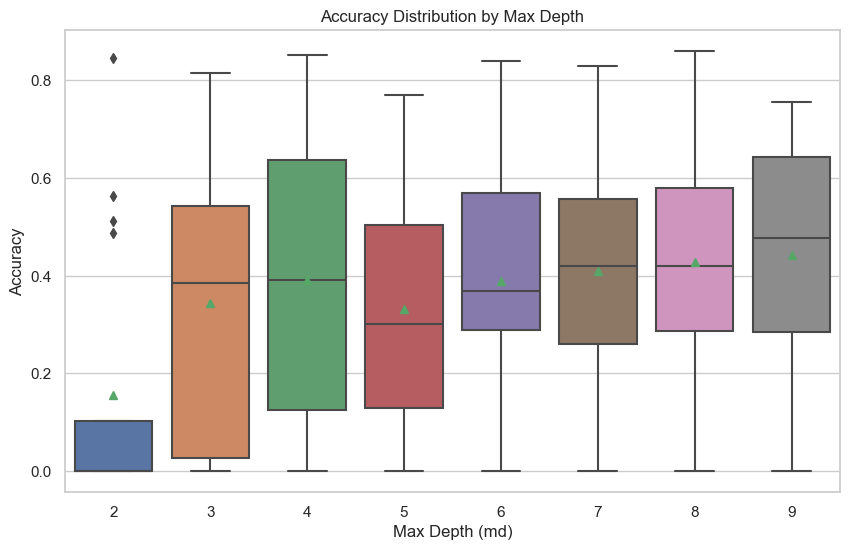

In [303]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='md', y='accuracy_trues', data=results_df,showmeans = True)

# Set plot title and labels
plt.title('Accuracy Distribution by Max Depth')
plt.xlabel('Max Depth (md)')
plt.ylabel('Accuracy')

# Show the plot
plt.show()

## Tree visualisations on full data

In [304]:
#Load importances
df_importances = pd.read_csv(f"FeatureImportances/{case}.csv")
#Load input data
df_input = pd.read_csv(f"../Data/{case}_DC_fy/input_f_sc01_Network_Existing_Generation_Full_2030.csv")

## Load output data 
df_output = pd.read_csv("../06.Benchmarking/K.Investments_per_hour/RTS24_mod1/3.Out/oT_Hourly_Investments_RTS24_mod1.csv",header = [0,1,2,3,4])

#Convert numerical investment values to booleans
for col in df_output.select_dtypes(include=['float64', 'int64']).columns:
    df_output[col] = df_output[col].apply(lambda x: 0.5 <= x)

In [305]:
#Filter input data based on importances 
nb_features = 10
selected_features = df_importances.iloc[:nb_features,:].Name
selected_input = df_input[selected_features]

In [316]:
import os
# Tree parameters
md = 4
mln = 1000

# Single investment decision
dtree = tree.DecisionTreeClassifier(max_depth=md, max_leaf_nodes=mln)

# Define the directory for saving plots
output_dir = f"TreePlots/{case}"  # Replace 'your_case_directory' with the actual case directory name

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Loop over line candidates
for col in df_output.columns[1:]:
    str_col = '_'.join(col[0:-1])
    # Train the model
    dtree = dtree.fit(selected_input, df_output.loc[:, col])
    
    # Plot the tree
    plt.figure(figsize=(20, 10))
    tree.plot_tree(dtree, feature_names=selected_input.columns, fontsize=5, filled=True)
    plt.title(f"Decision Tree for {str_col}")
    
    # Save the plot
    plt.savefig(os.path.join(output_dir, f"{str_col}.png"))
    plt.close()